# <center>Network Science</center>

## <center>Home Assignment #2: Network models</center>

### <center>Student: *{Zhiyenbay Olzhas }*</center>

#### <hr /> General Information

**Due Date:** 28.02.2016 23:59 <br \>
**Late submission policy:** -0.2 points per day <br \>


Please send your reports to <mailto:network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2016] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

In [1]:
from __future__ import print_function, division
import pandas as pd
import numpy as np
import pylab as pl
import networkx as nx

%matplotlib inline
for module in [pd, np, nx]:
    print(module.__name__, module.__version__)

pandas 0.17.1
numpy 1.10.4
networkx 1.9.1


## Problems

### Task 1

Consider Barabasi and Albert dynamical grow model. Two main ingredients of this model are *network growing* and *prefferential attachment*. Implement two restricted B&A-based models:
<br \>

**Model A**
<br \>
Lack of prefferential attachment, that is at each time-step form edges uniformly at random while network keeps growing.

**Model B**
<br \>
Lack of growing, that is fix total number of nodes, on each time-step randomly choose one and form edges with prefferential attachment.
<br \>

1. Generate networks according to the models above ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
4. Is scale-free property conserved in these models?

Analyse results with respect to various parameter settings

In [2]:
def degree_pdf(g):
    degrees = pd.Series(g.degree().values())
    return (degrees.value_counts()/degrees.count()).sort_index()
    
def degree_cdf(g):
    return degree_pdf(g).cumsum()

def degree_ccdf(g):
    return 1 - degree_cdf(g)

def plot_pdf_cdf(g):
    f, ax = pl.subplots(1,2, figsize=(15,3))
    ax[0].semilogx(degree_pdf(g), 's--')
    ax[0].set_xlabel('degree')
    ax[0].set_ylabel('probability')
    ax[0].set_title('PDF')
    degree_ccdf(g).plot(style='-*', loglog=True, ax=ax[1])
    ax[1].set_title('cCDF')
    ax[1].set_xlabel('degree')
    ax[1].set_ylabel('cCDF')


In [3]:
def draw_graph(g, jitter=False, title=None):
    if jitter:
        pl.figure(figsize=(15,5))
    else:
        pl.figure(figsize=(15,7))
    if not title:
        pl.title(str(g.number_of_nodes()) + ' nodes')
    else:
        pl.title(title + '\n' + str(g.number_of_nodes()) + ' nodes')
    nodelist = list(g.degree().keys())
    node_size = 30*np.asarray(g.degree().values())
    node_color = nodelist
    if jitter:
        k = 5/np.sqrt(g.number_of_nodes())
    else:
        k = 1/np.sqrt(g.number_of_nodes())
    nx.draw_networkx(g, nodelist=nodelist, pos=nx.spring_layout(g, k=k), node_size=node_size,
                     node_color=node_color, cmap='inferno', width=0.1, alpha=0.75, with_labels=False)

In [4]:
def plot_statistics(t_max=100, alpha=1, model='BA_preferential'):
    path_length = []
    clustering_coef = []
    node_degree = []
    times = np.unique(np.floor(np.append([0], np.logspace(0, np.log10(t_max), base=10))))
    alpha_title = 'm (number of new edges)'
    for t in range(0, t_max + 1):
        if t == 0:
            if model == 'BA_preferential':
                g = BA_graph_model(m=alpha)
            elif model == 'BA_uniform':
                g = BA_graph_model(m=alpha, proba='uniform')
            elif model == 'vertex_copying':
                g = vertex_copying_model(q=alpha)
                alpha_title = 'q'
        else:
            if model == 'BA_preferential':
                g = BA_graph_model(m=alpha, t=1, initial_graph=g)
            elif model == 'BA_uniform':
                g = BA_graph_model(m=alpha, proba='uniform', t=1, initial_graph=g)
            elif model == 'vertex_copying':
                g = vertex_copying_model(q=alpha, t=1, initial_graph=g)
                alpha_title = 'q (probability of remaining an edge)'
        
        if t in times:
            if nx.is_connected(g):
                path_length.append(nx.average_shortest_path_length(g))
            else:
                giant_component=sorted(nx.connected_component_subgraphs(g), key=len, reverse=True)[0]
                path_length.append(nx.average_shortest_path_length(giant_component))
            clustering_coef.append(nx.average_clustering(g))
            node_degree.append(np.mean(nx.degree(g).values()))
        
    if model == 'vertex_copying':
        jitter = True
    else:
        jitter = False
    draw_graph(g, jitter, title=alpha_title + ' = ' + str(alpha))
    plot_pdf_cdf(g)
    f, ax = pl.subplots(1, 3, sharex=True, figsize=(15,4))
    for axi in ax:
        axi.set_title(alpha_title + ' = ' + str(alpha))
        axi.set_xlabel('time')
        
    ax[0].plot(times, path_length, '-*')
    ax[0].set_ylabel('average shortest path length')
    
    ax[1].plot(times, clustering_coef, '-*')
    ax[1].set_ylabel('average clustering coefficient')
    
    ax[2].plot(times, node_degree, '-*')
    ax[2].set_ylabel('average node degree')
    

In [5]:
def BA_graph_model(t=0, m=1, n0=10, m0=10, proba='preferential', initial_graph=None):
    assert m0 >= n0
    assert t >= 0
    assert m >= 1
    if not initial_graph:
        g = nx.Graph()
        g.add_nodes_from(np.arange(n0))
        nodes = np.asarray(g.nodes())
        n_from = np.random.choice(nodes, m0)
        for i, node in enumerate(n_from):
            node_edges = g.neighbors(node)
            node_to = np.random.choice(nodes[~np.in1d(nodes, np.append(node_edges, [node]))], 1)[0]
            g.add_edge(node, node_to)
    else:
        g = initial_graph
    
    for tm in np.arange(0, t):
        nodes = np.asarray(g.nodes())
        new_node = nodes.max() + 1
        if proba == 'uniform':
            new_edges = np.random.choice(nodes, m, replace=False)
        elif proba == 'preferential':
            degrees = np.asarray(g.degree().values())
            degrees = degrees/degrees.sum()
            new_edges = np.random.choice(nodes, m, replace=False, p=degrees)
        g.add_node(new_node)
        g.add_edges_from(zip(np.repeat(new_node, m), new_edges))
    return g
    

# BA_preferential

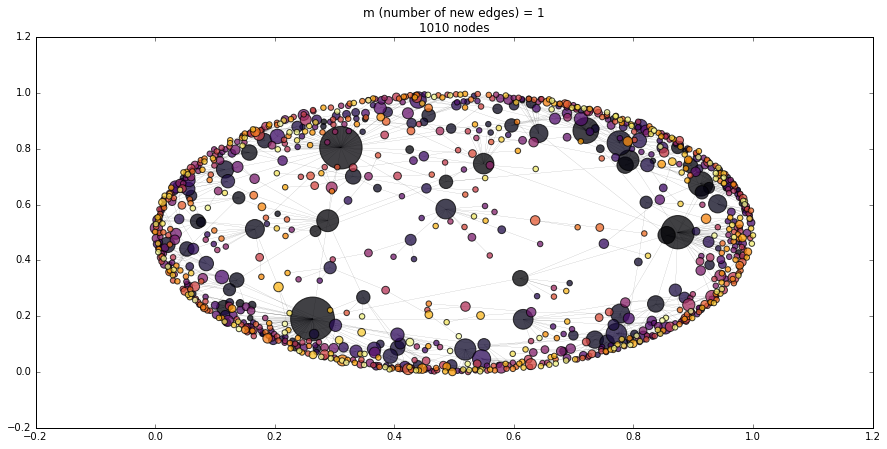

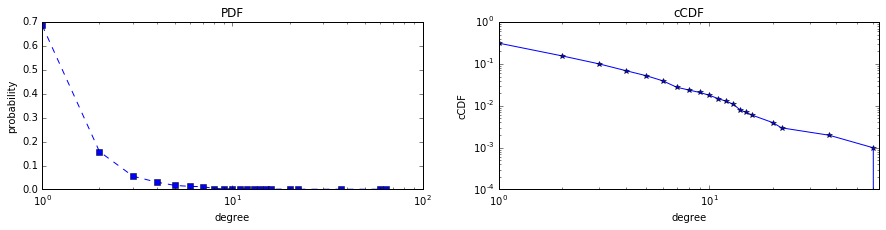

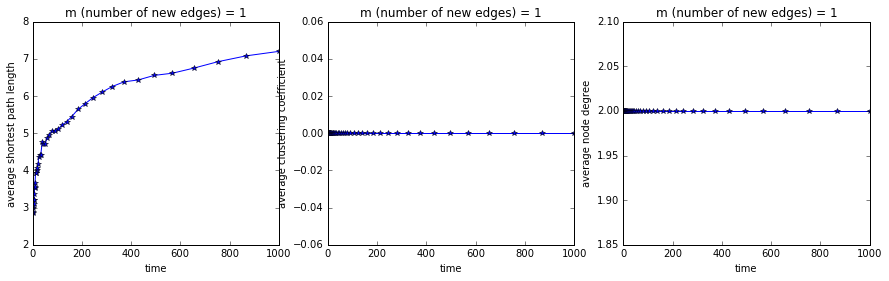

In [6]:
plot_statistics(alpha=1, t_max=1000, model='BA_preferential')


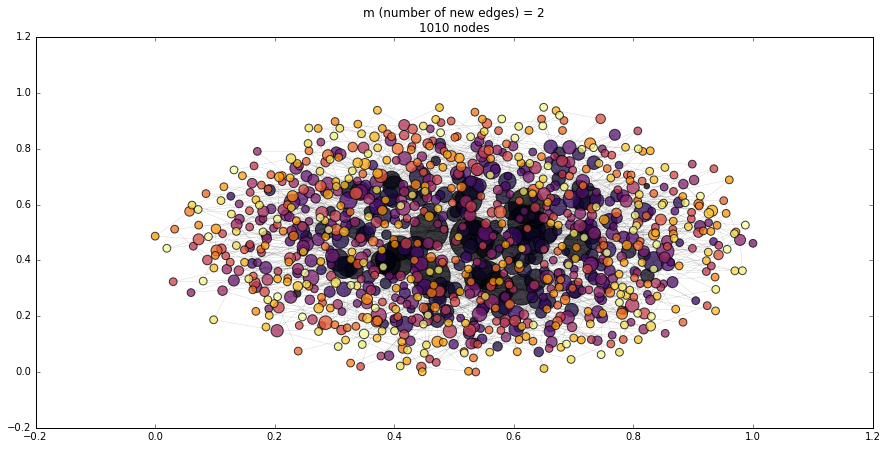

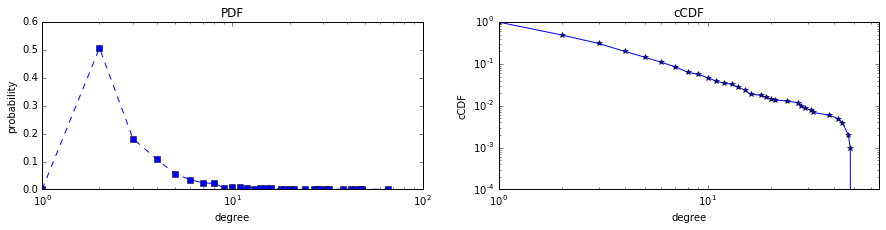

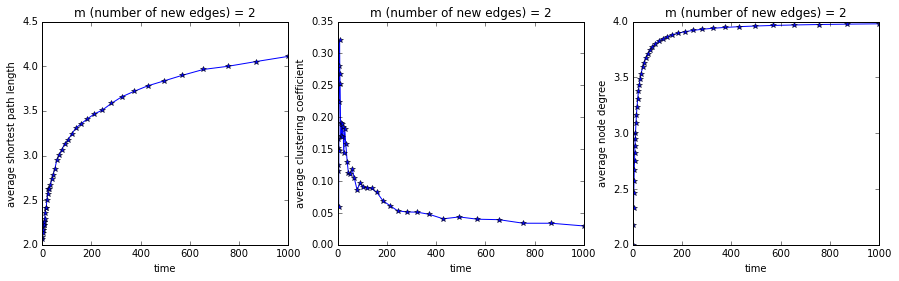

In [7]:
plot_statistics(alpha=2, t_max=1000, model='BA_preferential')


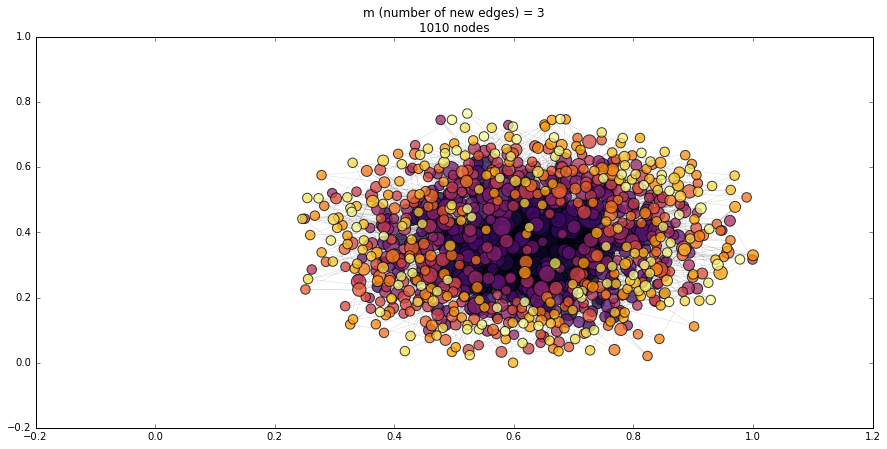

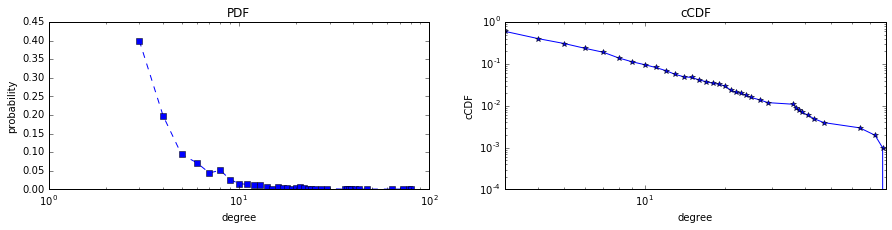

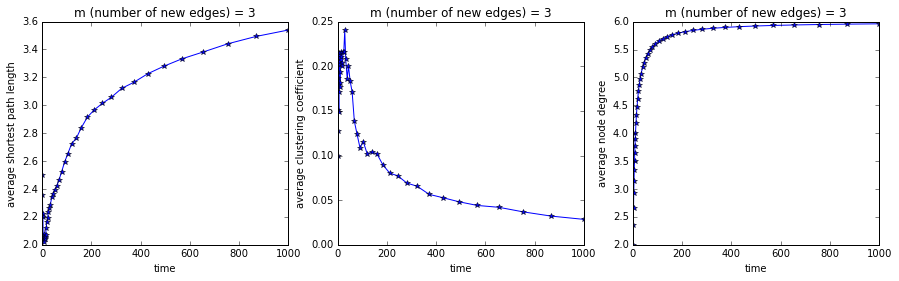

In [8]:
plot_statistics(alpha=3, t_max=1000, model='BA_preferential')


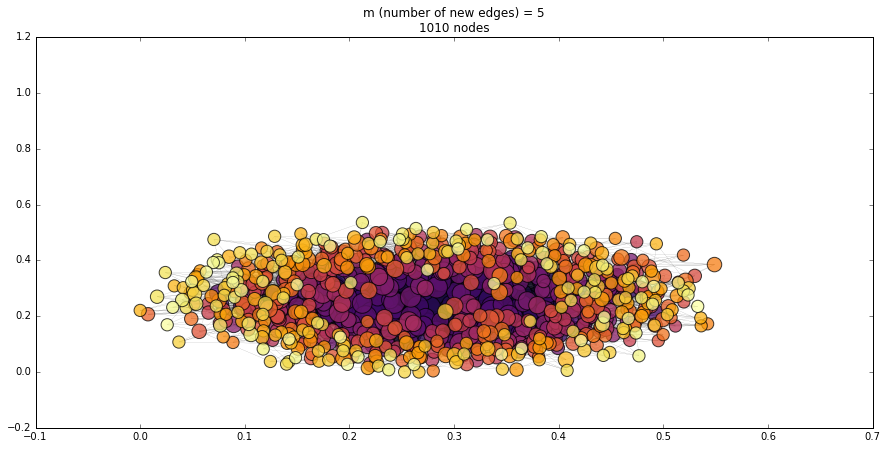

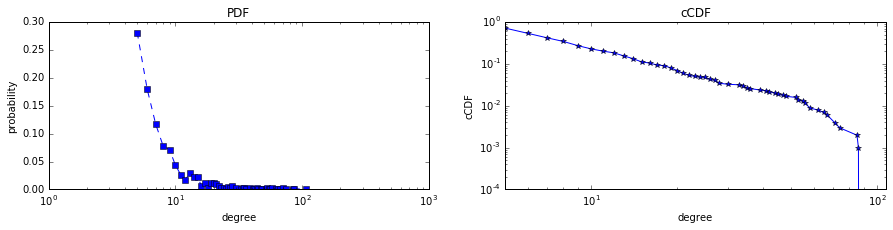

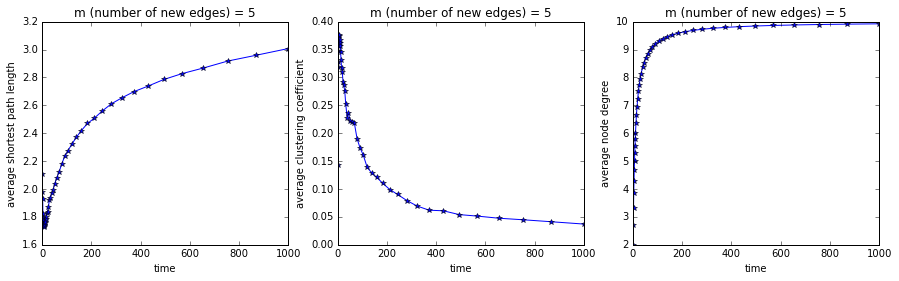

In [9]:
plot_statistics(alpha=5, t_max=1000, model='BA_preferential')


# BA_uniform

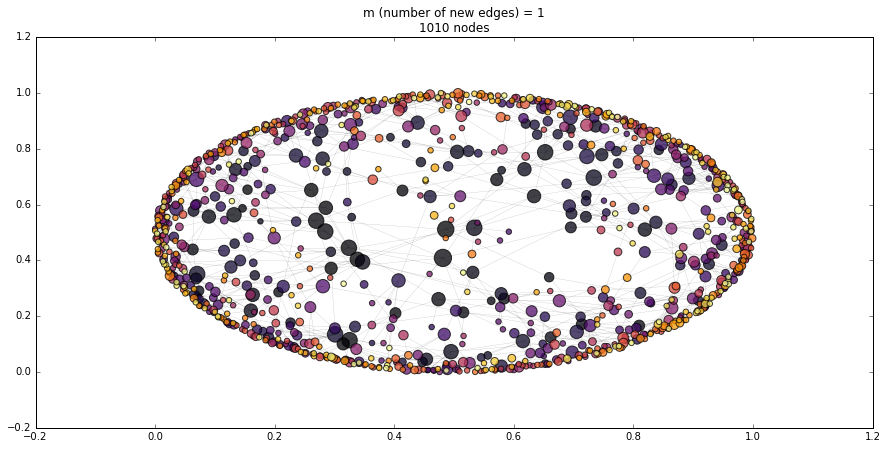

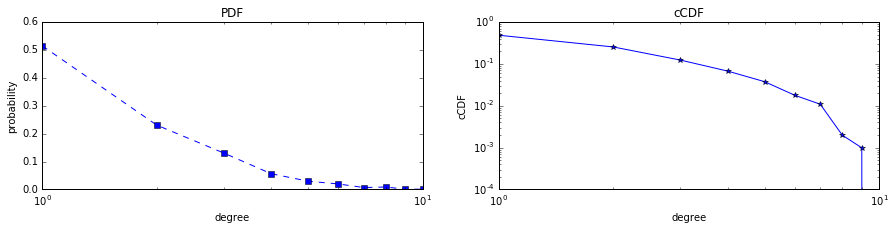

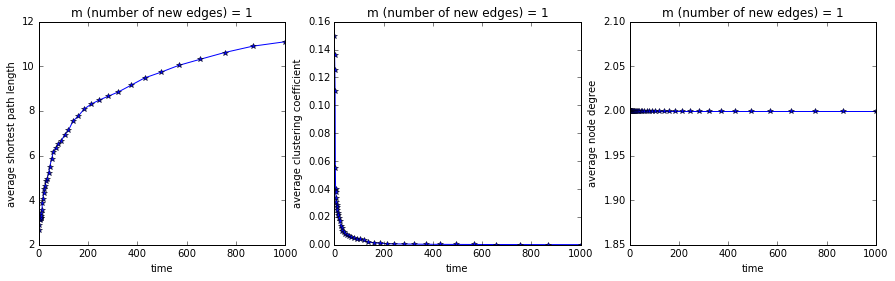

In [10]:
plot_statistics(alpha=1, t_max=1000, model='BA_uniform')

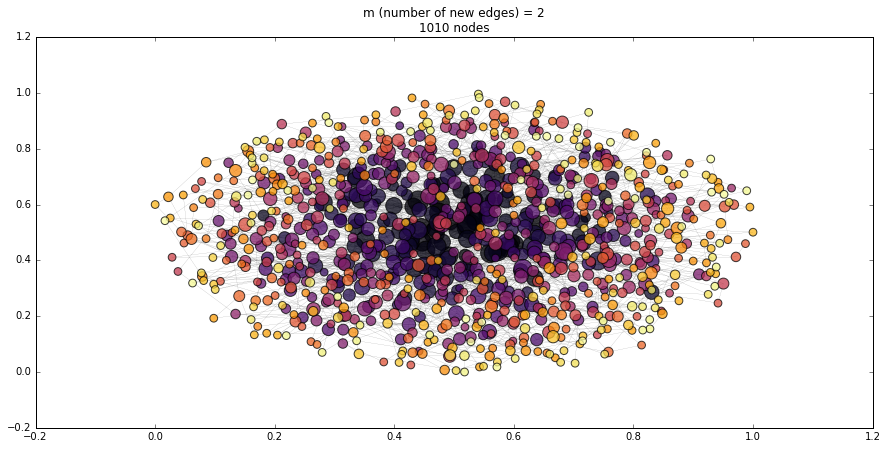

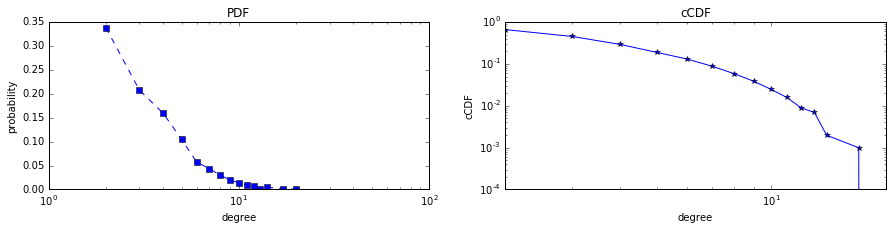

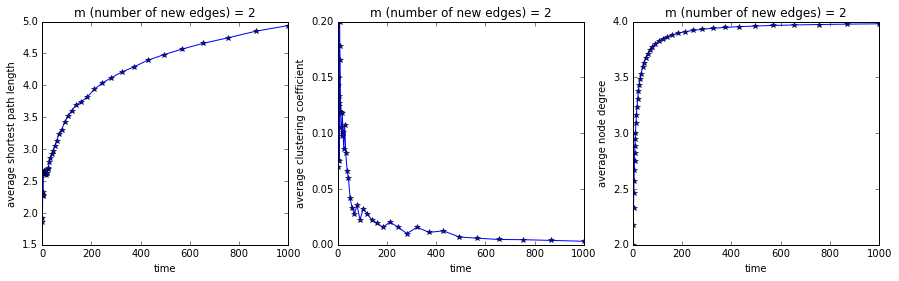

In [11]:
plot_statistics(alpha=2, t_max=1000, model='BA_uniform')

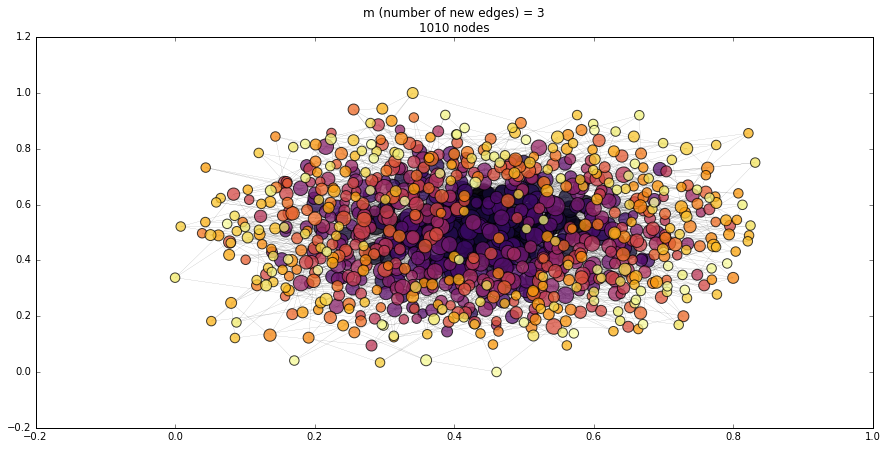

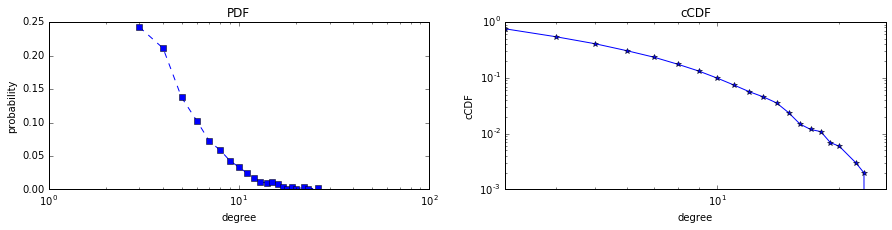

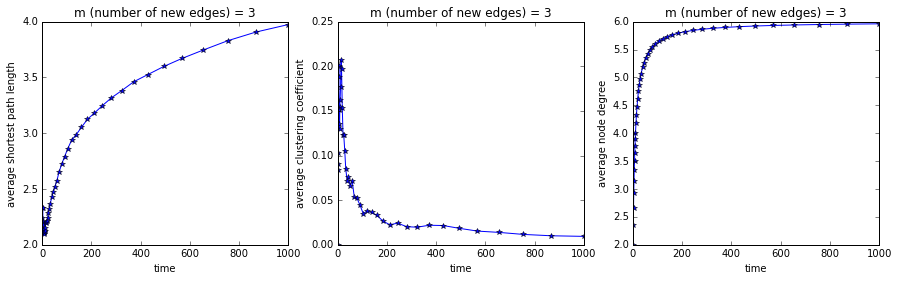

In [12]:
plot_statistics(alpha=3, t_max=1000, model='BA_uniform')

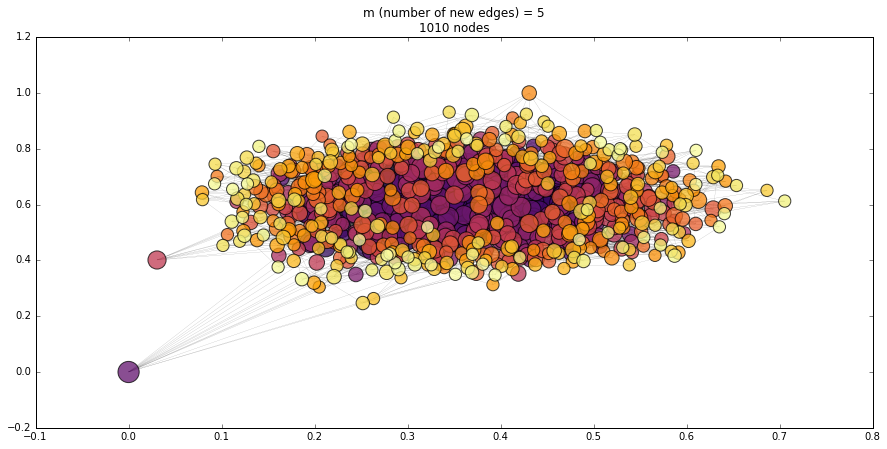

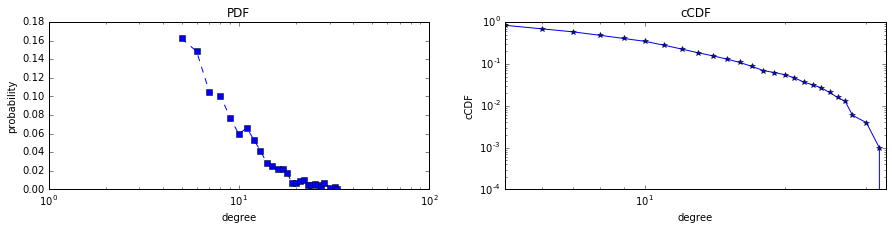

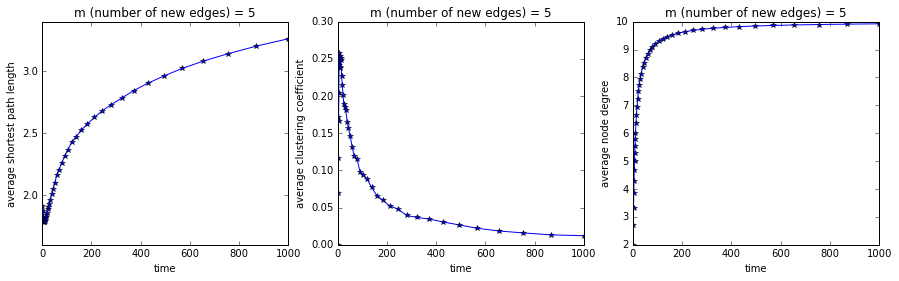

In [13]:
plot_statistics(alpha=5, t_max=1000, model='BA_uniform')

### the scale-free property is conserved in all these models

### <hr /> Task 2

Consider the following  "Vertex copying model" of growing network.

At every time step a random vertex from already existing vertices is selected and duplicated together with all edges, such that  every edge of the  vertex
* is copied with probability $q$
* is rewired to any other randomly selected vertex with probability $1-q$


Starting state is defined by some small number of randomly connected vertices.

The model can generate both directed and undirected networks.

1. Generate  graphs based on the model ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
    
Analyse results with respect to various parameter settings

In [14]:
def vertex_copying_model(t=0, q=1, n0=10, m0=10, initial_graph=None):
    assert m0 >= n0
    assert t >= 0
    assert (q <= 1) and (q >= 0) 
    if not initial_graph:
        g = nx.Graph()
        g.add_nodes_from(np.arange(n0))
        nodes = np.asarray(g.nodes())
        n_from = np.random.choice(nodes, m0)
        for i, node in enumerate(n_from):
            node_edges = g.neighbors(node)
            node_to = np.random.choice(nodes[~np.in1d(nodes, np.append(node_edges, [node]))], 1)[0]
            g.add_edge(node, node_to)
    else:
        g = initial_graph
    
    for tm in np.arange(0, t):
        nodes = np.asarray(g.nodes())
        new_node = nodes.max() + 1
        copying_node = np.random.choice(nodes, 1)[0]
        node_edges = g.neighbors(copying_node)
        for node in node_edges:
            if np.random.rand() < q:
                g.add_edge(new_node, node)
            else:
                g.add_edge(new_node, np.random.choice(nodes[nodes != node], 1)[0])
    return g
    

# vertex_copying

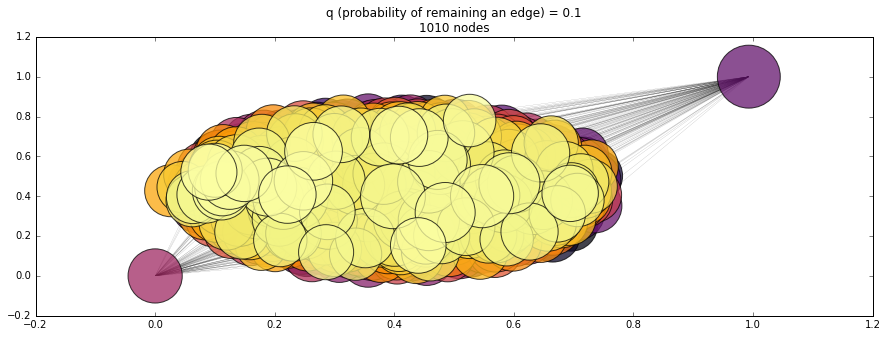

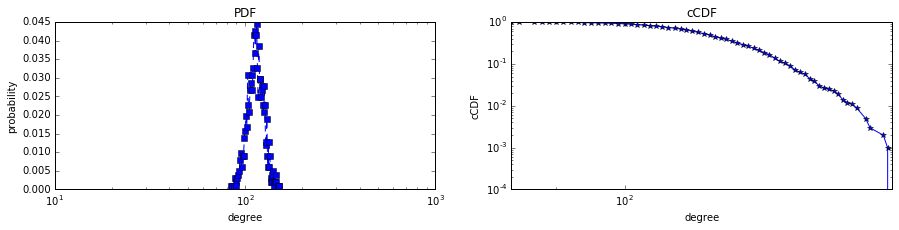

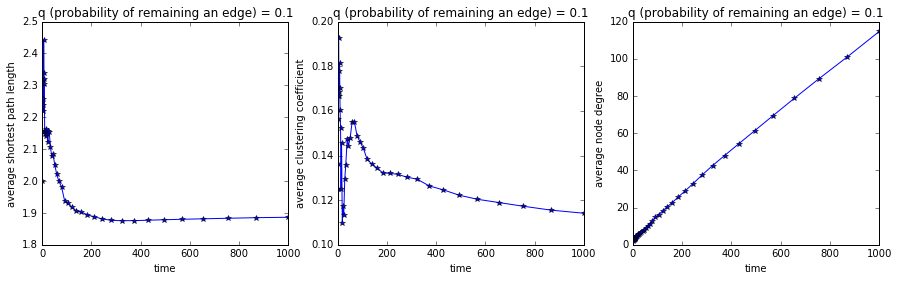

In [15]:
plot_statistics(alpha=0.1, t_max=1000, model='vertex_copying')

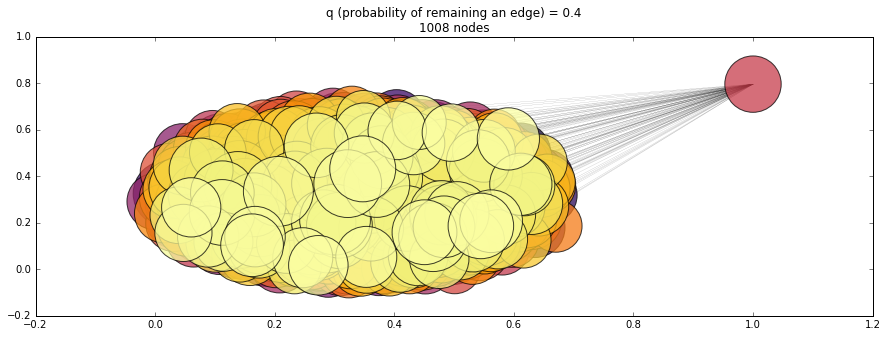

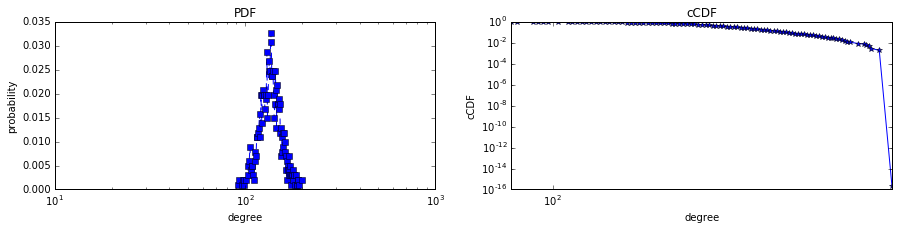

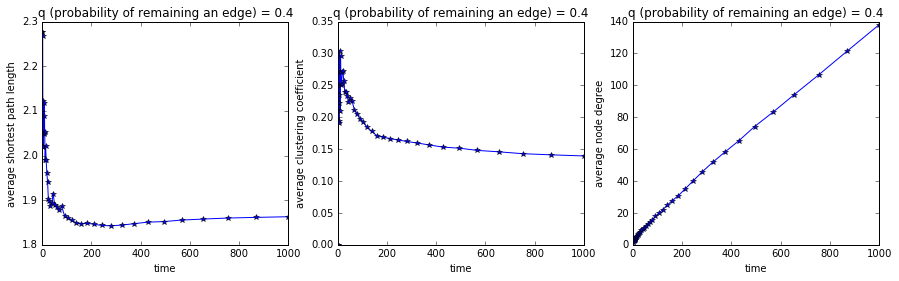

In [16]:
plot_statistics(alpha=0.4, t_max=1000, model='vertex_copying')

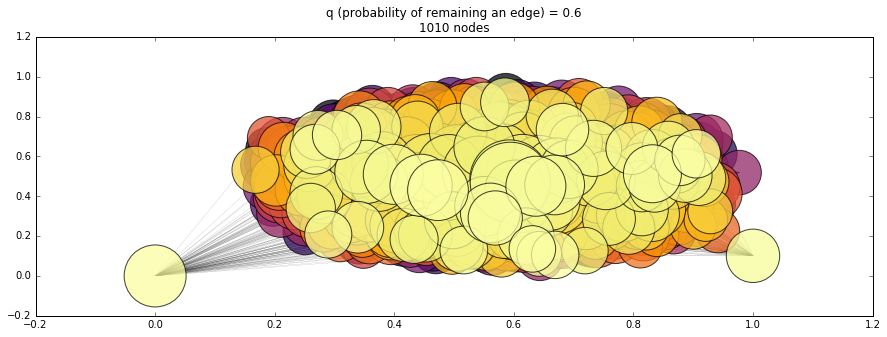

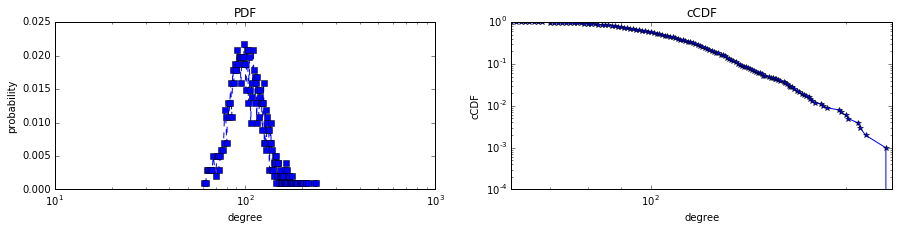

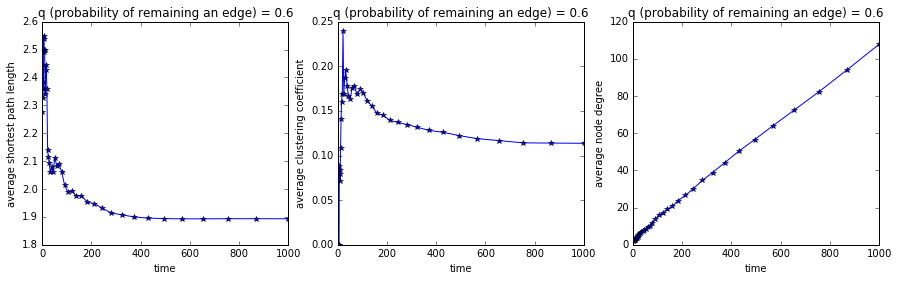

In [17]:
plot_statistics(alpha=0.6, t_max=1000, model='vertex_copying')

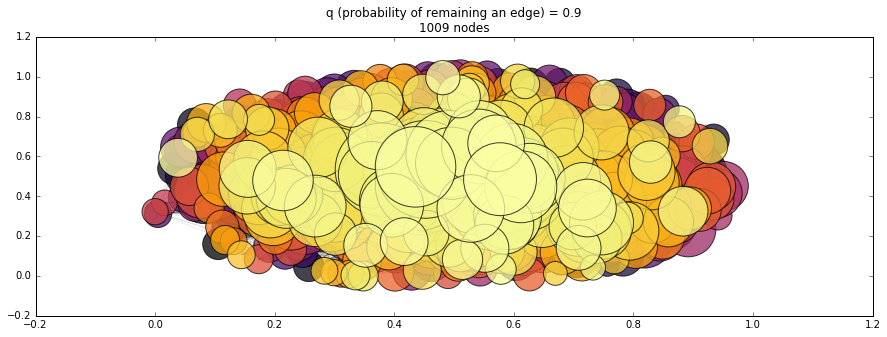

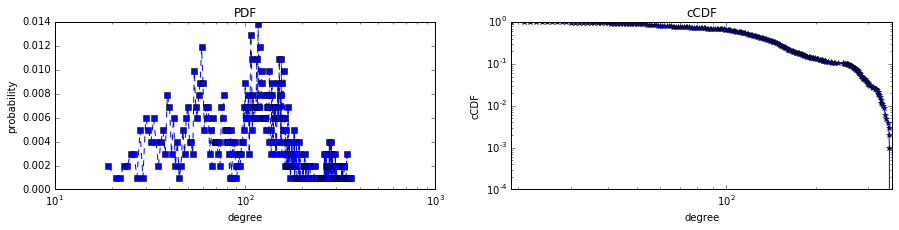

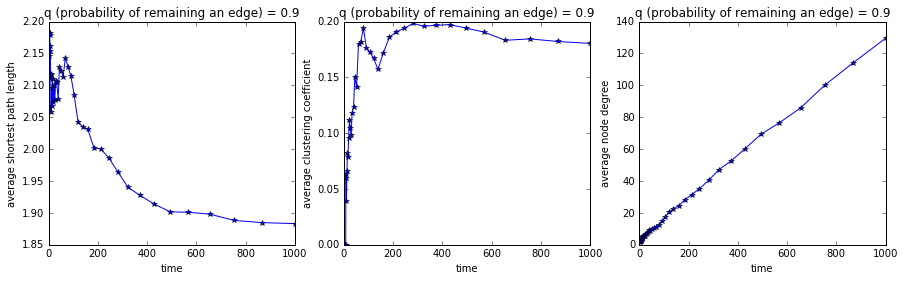

In [18]:
plot_statistics(alpha=0.9, t_max=1000, model='vertex_copying')